In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# https://github.com/tensorflow/tensorflow/issues/24828
# Allowing GPU memory growth
# https://www.tensorflow.org/guide/using_gpu

# To Answer on ---- https://stackoverflow.com/questions/53698035/failed-to-get-convolution-algorithm-this-is-probably-because-cudnn-failed-to-in

In [2]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' for checking memory occupied by variables'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

In [3]:
import os 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.metrics import roc_curve, auc, precision_recall_curve # roc curve tools
from sklearn.model_selection import train_test_split

from skimage.transform import resize

In [4]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, add, multiply, Lambda
from keras.layers import AveragePooling2D, average, UpSampling2D, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.initializers import glorot_normal, random_normal, random_uniform
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [5]:
import losses 
import utils 
import newmodels

In [6]:
img_row = 192
img_col = 256
img_chan = 3
epochnum = 50
batchnum = 16  
smooth = 1.

In [7]:
input_size = (img_row, img_col, img_chan)
    
sgd = SGD(lr=0.01, momentum=0.90, decay=1e-6)
adam = Adam(lr=1e-3) 

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
curr_dir = os.getcwd()
train_dir = os.path.join(curr_dir, 'resized_train')
gt_dir = os.path.join(curr_dir, 'resized_gt')
orig_dir = os.path.join(curr_dir, 'orig_gt')

In [9]:
img_list = os.listdir(train_dir)
num_imgs = len(img_list)

orig_data = np.zeros((num_imgs, img_row, img_col, img_chan))
orig_masks = np.zeros((num_imgs, img_row, img_col,1))

In [10]:
for idx,img_name in enumerate(img_list): 
    orig_data[idx] = plt.imread(os.path.join(train_dir, img_name))
    orig_masks[idx,:,:,0] = plt.imread(os.path.join(gt_dir, img_name.split('.')[0] + "_segmentation.png"))

In [11]:
indices = np.arange(0,num_imgs,1)

imgs_train, imgs_test, \
imgs_mask_train, orig_imgs_mask_test,\
trainIdx, testIdx = train_test_split(orig_data,orig_masks, indices,test_size=0.25)

In [12]:
imgs_train /= 255
imgs_test /=255

In [13]:
estop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, mode='auto')
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_final_dsc', 
                             verbose=1, save_best_only=True, save_weights_only=True, mode='max')

In [14]:
gt1 = imgs_mask_train[:,::8,::8,:]
gt2 = imgs_mask_train[:,::4,::4,:]
gt3 = imgs_mask_train[:,::2,::2,:]
gt4 = imgs_mask_train
gt_train = [gt1,gt2,gt3,gt4]

In [15]:
model = newmodels.attn_reg(sgd, input_size, losses.focal_tversky)

In [16]:
for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

                     orig_data:   2.8GiB
                    imgs_train:   2.1GiB
                    orig_masks: 972.8MiB
                     imgs_test: 730.1MiB
                           gt4: 729.4MiB
               imgs_mask_train: 729.4MiB
           orig_imgs_mask_test: 243.4MiB
                      img_list:  20.6KiB
                       indices:  20.4KiB
                      trainIdx:  15.3KiB


In [17]:
del orig_data
del orig_masks

In [18]:
hist = model.fit(imgs_train, gt_train, validation_split=0.15,
                 shuffle=True, epochs=epochnum, batch_size=batchnum, 
                 verbose=True, callbacks=[checkpoint])#, callbacks=[estop,tb])

Train on 1653 samples, validate on 292 samples
Epoch 1/50
1653/1653 [==============================] - 38s 23ms/step - loss: 1.6462 - pred1_loss: 0.3974 - pred2_loss: 0.4038 - pred3_loss: 0.4612 - final_loss: 0.3838 - pred1_dsc: 0.6412 - pred2_dsc: 0.6384 - pred3_dsc: 0.5642 - final_dsc: 0.5485 - val_loss: 2.1379 - val_pred1_loss: 0.4499 - val_pred2_loss: 0.6719 - val_pred3_loss: 0.5110 - val_final_loss: 0.5052 - val_pred1_dsc: 0.5560 - val_pred2_dsc: 0.3839 - val_pred3_dsc: 0.4804 - val_final_dsc: 0.3761

Epoch 00001: val_final_dsc improved from -inf to 0.37613, saving model to weights.hdf5
Epoch 2/50
1653/1653 [==============================] - 32s 20ms/step - loss: 1.2137 - pred1_loss: 0.3210 - pred2_loss: 0.3233 - pred3_loss: 0.3292 - final_loss: 0.2403 - pred1_dsc: 0.7372 - pred2_dsc: 0.7352 - pred3_dsc: 0.7281 - final_dsc: 0.7164 - val_loss: 1.2293 - val_pred1_loss: 0.3091 - val_pred2_loss: 0.3310 - val_pred3_loss: 0.3374 - val_final_loss: 0.2517 - val_pred1_dsc: 0.7582 - val_pre

1653/1653 [==============================] - 32s 20ms/step - loss: 0.7439 - pred1_loss: 0.2050 - pred2_loss: 0.2060 - pred3_loss: 0.2077 - final_loss: 0.1252 - pred1_dsc: 0.8532 - pred2_dsc: 0.8523 - pred3_dsc: 0.8516 - final_dsc: 0.8510 - val_loss: 0.9778 - val_pred1_loss: 0.2534 - val_pred2_loss: 0.2714 - val_pred3_loss: 0.2704 - val_final_loss: 0.1827 - val_pred1_dsc: 0.8302 - val_pred2_dsc: 0.8209 - val_pred3_dsc: 0.8207 - val_final_dsc: 0.8158

Epoch 00016: val_final_dsc did not improve from 0.85436
Epoch 17/50
1653/1653 [==============================] - 32s 19ms/step - loss: 0.7118 - pred1_loss: 0.1965 - pred2_loss: 0.1976 - pred3_loss: 0.1992 - final_loss: 0.1186 - pred1_dsc: 0.8637 - pred2_dsc: 0.8619 - pred3_dsc: 0.8611 - final_dsc: 0.8604 - val_loss: 0.8924 - val_pred1_loss: 0.2396 - val_pred2_loss: 0.2453 - val_pred3_loss: 0.2479 - val_final_loss: 0.1596 - val_pred1_dsc: 0.8441 - val_pred2_dsc: 0.8433 - val_pred3_dsc: 0.8416 - val_final_dsc: 0.8394

Epoch 00017: val_final_d

1653/1653 [==============================] - 32s 20ms/step - loss: 0.5851 - pred1_loss: 0.1630 - pred2_loss: 0.1638 - pred3_loss: 0.1656 - final_loss: 0.0927 - pred1_dsc: 0.8920 - pred2_dsc: 0.8915 - pred3_dsc: 0.8905 - final_dsc: 0.8898 - val_loss: 0.9265 - val_pred1_loss: 0.2403 - val_pred2_loss: 0.2584 - val_pred3_loss: 0.2589 - val_final_loss: 0.1689 - val_pred1_dsc: 0.8519 - val_pred2_dsc: 0.8455 - val_pred3_dsc: 0.8453 - val_final_dsc: 0.8439

Epoch 00031: val_final_dsc did not improve from 0.87279
Epoch 32/50
1653/1653 [==============================] - 33s 20ms/step - loss: 0.5635 - pred1_loss: 0.1573 - pred2_loss: 0.1580 - pred3_loss: 0.1597 - final_loss: 0.0884 - pred1_dsc: 0.8949 - pred2_dsc: 0.8949 - pred3_dsc: 0.8937 - final_dsc: 0.8933 - val_loss: 0.7511 - val_pred1_loss: 0.2059 - val_pred2_loss: 0.2081 - val_pred3_loss: 0.2099 - val_final_loss: 0.1272 - val_pred1_dsc: 0.8616 - val_pred2_dsc: 0.8528 - val_pred3_dsc: 0.8516 - val_final_dsc: 0.8507

Epoch 00032: val_final_d


Epoch 00046: val_final_dsc improved from 0.87279 to 0.87392, saving model to weights.hdf5
Epoch 47/50
1653/1653 [==============================] - 32s 20ms/step - loss: 0.4741 - pred1_loss: 0.1328 - pred2_loss: 0.1339 - pred3_loss: 0.1360 - final_loss: 0.0715 - pred1_dsc: 0.9157 - pred2_dsc: 0.9147 - pred3_dsc: 0.9134 - final_dsc: 0.9132 - val_loss: 0.7931 - val_pred1_loss: 0.2178 - val_pred2_loss: 0.2187 - val_pred3_loss: 0.2208 - val_final_loss: 0.1358 - val_pred1_dsc: 0.8663 - val_pred2_dsc: 0.8664 - val_pred3_dsc: 0.8649 - val_final_dsc: 0.8646

Epoch 00047: val_final_dsc did not improve from 0.87392
Epoch 48/50
1653/1653 [==============================] - 33s 20ms/step - loss: 0.4211 - pred1_loss: 0.1191 - pred2_loss: 0.1194 - pred3_loss: 0.1213 - final_loss: 0.0612 - pred1_dsc: 0.9272 - pred2_dsc: 0.9267 - pred3_dsc: 0.9257 - final_dsc: 0.9254 - val_loss: 0.7599 - val_pred1_loss: 0.2092 - val_pred2_loss: 0.2100 - val_pred3_loss: 0.2119 - val_final_loss: 0.1288 - val_pred1_dsc: 0

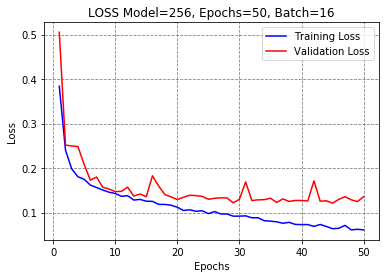

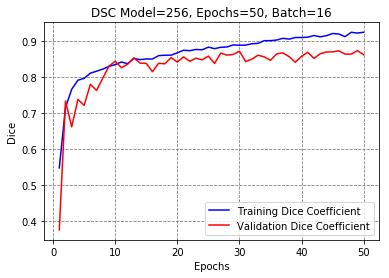

In [19]:
h = hist.history
utils.plot(h, epochnum, batchnum, img_col, 1)

In [20]:
del imgs_train

In [21]:
num_test = len(imgs_test)
_,_,_,preds = model.predict(imgs_test)
#preds = model.predict(imgs_test)   #use this if the model is unet

In [22]:
preds_up=[]
dsc = np.zeros((num_test,1))
recall = np.zeros_like(dsc)
tn = np.zeros_like(dsc)
prec = np.zeros_like(dsc)

thresh = 0.5

In [47]:
# check the predictions from the trained model 
for i in range(num_test):
    #gt = orig_masks[testIdx[i]]
    name = img_list[testIdx[i]]
    gt = plt.imread(os.path.join(orig_dir, name.split('.')[0] + "_segmentation.png")) 

    #pred_up = cv2.resize(preds[i], (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_up = resize(preds[i], (gt.shape[0], gt.shape[1]))
    zzz = pred_up > thresh
    zzz = zzz.reshape((gt.shape[0], gt.shape[1]))
    dsc[i] = utils.check_preds(pred_up > thresh, gt)
    recall[i], _, prec[i] = utils.auc(gt, zzz)

In [48]:
print('-'*30)
print('At threshold =', thresh)
print('\n DSC \t\t{0:^.3f} \n Recall \t{1:^.3f} \n Precision\t{2:^.3f}'.format(
        np.sum(dsc)/num_test,  
        np.sum(recall)/num_test,
        np.sum(prec)/num_test ))

------------------------------
At threshold = 0.5

 DSC 		0.841 
 Recall 	0.911 
 Precision	0.824


In [49]:
# check the predictions with the best saved model from checkpoint
model.load_weights("weights.hdf5")
_,_,_,preds = model.predict(imgs_test)
#preds = model.predict(imgs_test)   #use this if the model is unet

In [50]:
preds_up=[]
dsc = np.zeros((num_test,1))
recall = np.zeros_like(dsc)
tn = np.zeros_like(dsc)
prec = np.zeros_like(dsc)

In [51]:
for i in range(num_test):
    #gt = orig_masks[testIdx[i]]
    name = img_list[testIdx[i]]
    gt = plt.imread(os.path.join(orig_dir, name.split('.')[0] + "_segmentation.png")) 

    #pred_up = cv2.resize(preds[i], (gt.shape[1], gt.shape[0]), interpolation=cv2.INTER_NEAREST)
    pred_up = resize(preds[i], (gt.shape[1], gt.shape[0]))
    zzz = pred_up > thresh
    zzz = zzz.reshape((gt.shape[0], gt.shape[1]))    
    dsc[i] = utils.check_preds(pred_up > thresh, gt)
    recall[i], _, prec[i] = utils.auc(gt, zzz)

In [52]:
print('-'*30)
print('USING HDF5 saved model at thresh=', thresh)
print('\n DSC \t\t{0:^.3f} \n Recall \t{1:^.3f} \n Precision\t{2:^.3f}'.format(
        np.sum(dsc)/num_test,  
        np.sum(recall)/num_test,
        np.sum(prec)/num_test ))

------------------------------
USING HDF5 saved model at thresh= 0.5

 DSC 		0.323 
 Recall 	0.335 
 Precision	0.327


In [65]:
#plot precision-recall 
y_true = orig_imgs_mask_test.ravel() 
y_preds = preds.ravel() 
precision, recall, thresholds = precision_recall_curve(y_true > thresh, y_preds)

Text(0.5,1,'Precision-Recall Curve')

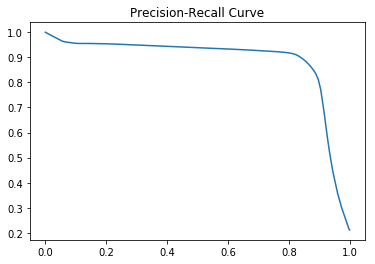

In [68]:
plt.figure(20)
plt.plot(recall,precision)
plt.title('Precision-Recall Curve')